In [1]:
from datetime import datetime
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from vnstock3 import Vnstock
import pandas_ta as ta
import numpy as np
import F 
from prophet import Prophet

D:\DSP\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
data_VN30 = vn30.quote.history(start='2023-01-01', end = current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
data_VNI = vni.quote.history(start='2023-01-01', end = current_date, to_df=True)

2024-07-01 07:31:05,268 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-07-01 07:31:05,584 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [4]:
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index()
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)

    # Thêm chỉ báo EMA
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)

    # Thêm chỉ báo RSI
    data['rsi'] = ta.rsi(data['close'], length=14)

    # Thêm chỉ báo MACD
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index()
    return data

In [6]:
data_VNI = process_data(data_VNI)
data_VN30 = process_data(data_VN30)

In [7]:
def model_ARIMA(data):
    data = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    stepwise_model = auto_arima(data['close'], trace=True, suppress_warnings=True, stepwise=True)
    model = ARIMA(data['close'], order=stepwise_model.order)
    model_fit = model.fit()
    return model_fit

def output_ARIMA(data, trend):
    data_features = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_ARIMA(data_features)
    next_day_forecast = model.forecast(steps=10)
    
    return np.mean(next_day_forecast)

In [8]:
def model_Prophet(data):
    data = data[['time', 'close']].copy()
    data.rename(columns={'time': 'ds', 'close': 'y'}, inplace=True)
    model = Prophet()
    model.fit(data)
    return model

def output_Prophet(data, k):
    data_features = data[['time', 'close']].copy()
    data_features.dropna(inplace=True)
    
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_Prophet(data_features)
    future = model.make_future_dataframe(periods=1)
    forecast = model.predict(future)
    
    # Get the predicted price (yhat) for the last row
    predicted_price = forecast['yhat'].iloc[-3:].mean()
    
    return predicted_price

In [9]:
def test(data, k):
    # Ensure the 'Price' column is properly referenced
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Calculate predicted price for each row starting from index k
    for i in range(k, len(data)):
        # Get data for the previous k days to predict the price for the current day
        historical_data_arima = data.iloc[i-k:i][['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
        historical_data_prophet = data.iloc[i-k:i][['time', 'close']]
        # Assuming output_ARIMA returns the predicted price based on previous data
        predicted_price_arima = output_ARIMA(historical_data_arima, k)
        predicted_price_prophet = output_Prophet(historical_data_prophet, k)
        # Calculate the price difference between the last day in the prediction data and the predicted price
        price_difference_arima = predicted_price_arima - data.iloc[i-1]['close']  # Make sure 'price' is correctly referenced
        price_difference_prophet = predicted_price_prophet - data.iloc[i-1]['close'] 
        # Update position based on calculated price difference
        if price_difference_arima > 2 and price_difference_prophet > 2:
            data_output.loc[i, 'position'] = 1
        elif price_difference_arima < -2  and price_difference_prophet < -2 :
            data_output.loc[i, 'position'] = -1
    data_output.dropna(inplace = True)
    return data_output

In [10]:
%%capture
data_VNI_position = test(data_VNI, 30)
data_VN30_position = test(data_VN30, 30)

Margin: 0.5677733925265919
MDD: (102.68142857142884, 0.07983131210703283)

   Total trading quantity: 24
         Profit per trade: 0.1349999999999909
             Total Profit: 3.2
         Profit after fee: -6.7
 Trading quantity per day: 0.07142857142857142
 Profit per day after fee: -0.019940476190476192
                   Return: -0.003872287017999033
          Profit per year: -4.980651731160896
                  HitRate: 0.375
          HitRate per day: 0.05970149253731343


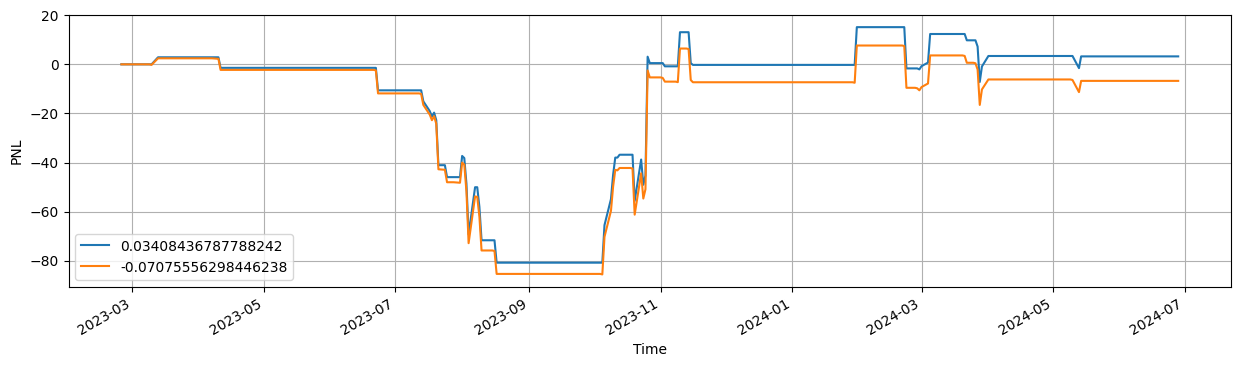

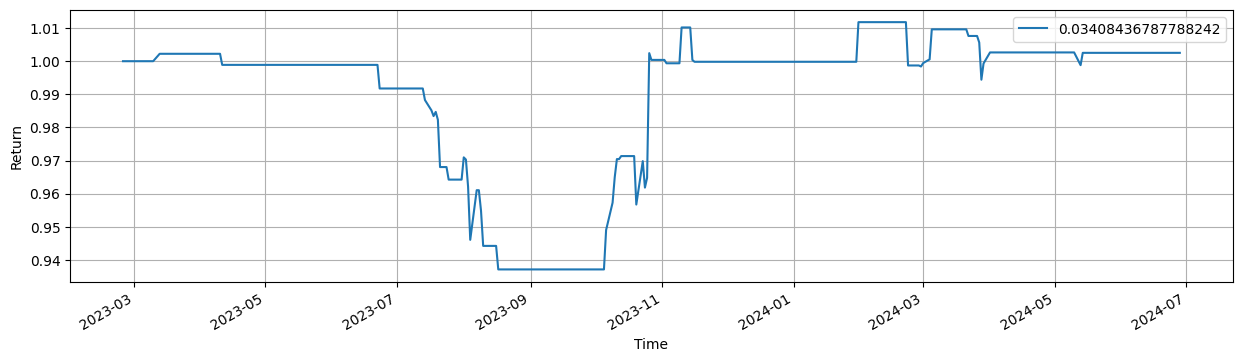

In [11]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 15.363909496959696
MDD: (68.25642857142861, 0.05319691414587334)

   Total trading quantity: 24
         Profit per trade: 3.635833333333352
             Total Profit: 87.3
         Profit after fee: 77.3
 Trading quantity per day: 0.07142857142857142
 Profit per day after fee: 0.2300595238095238
                   Return: 0.044785120390775084
          Profit per year: 57.4633401221996
                  HitRate: 0.5416666666666666
          HitRate per day: 0.056716417910447764


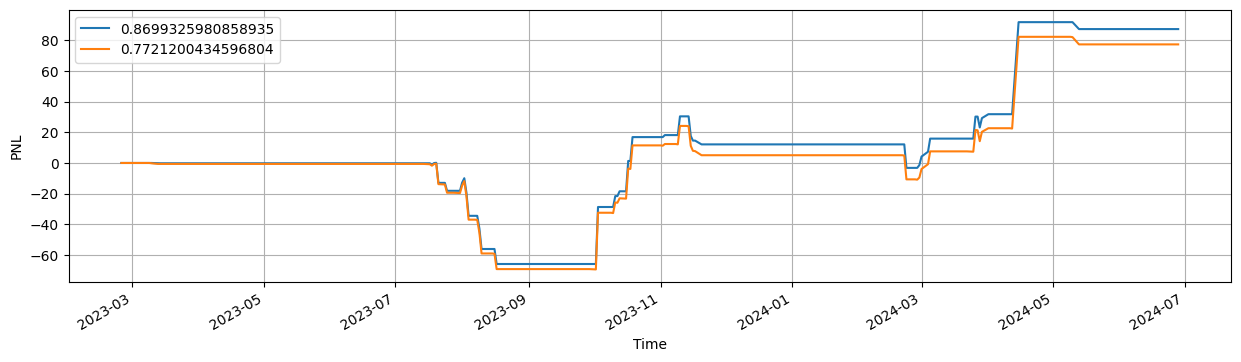

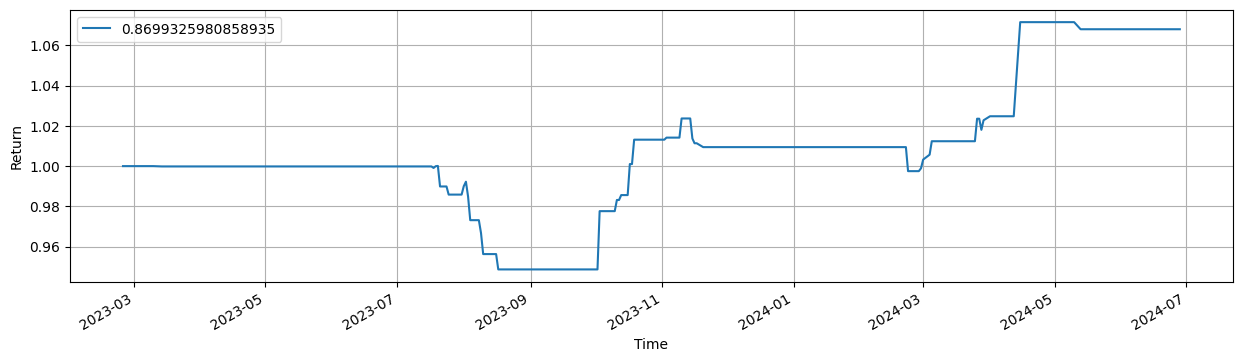

In [12]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [13]:
%%capture
data_VNI_position = test(data_VNI, 15)
data_VN30_position = test(data_VN30, 15)

Margin: 9.220602338845628
MDD: (34.65386904761928, 0.02659136667251326)

   Total trading quantity: 47
         Profit per trade: 2.1431914893616977
             Total Profit: 100.7
         Profit after fee: 80.5
 Trading quantity per day: 0.13988095238095238
 Profit per day after fee: 0.23958333333333334
                   Return: 0.04591939752875266
          Profit per year: 59.84215885947047
                  HitRate: 0.5106382978723404
          HitRate per day: 0.0955223880597015


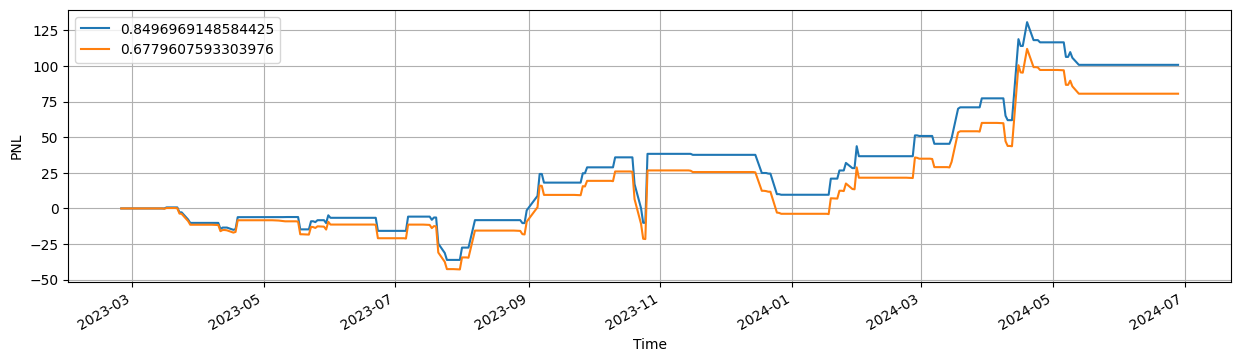

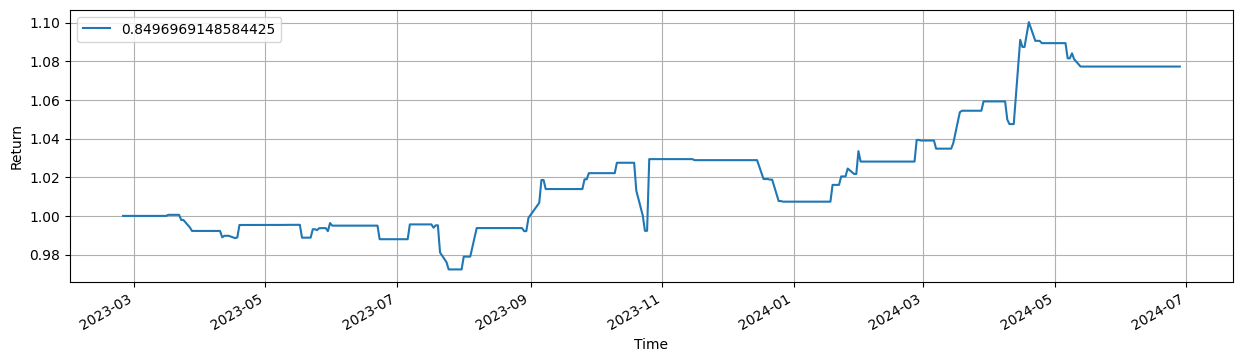

In [14]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 10.799542623546515
MDD: (53.16044642857155, 0.0416422108950114)

   Total trading quantity: 45
         Profit per trade: 2.4797777777777656
             Total Profit: 111.6
         Profit after fee: 92.3
 Trading quantity per day: 0.13392857142857142
 Profit per day after fee: 0.2747023809523809
                   Return: 0.053747495654987335
          Profit per year: 68.61405295315683
                  HitRate: 0.5555555555555556
          HitRate per day: 0.10149253731343283


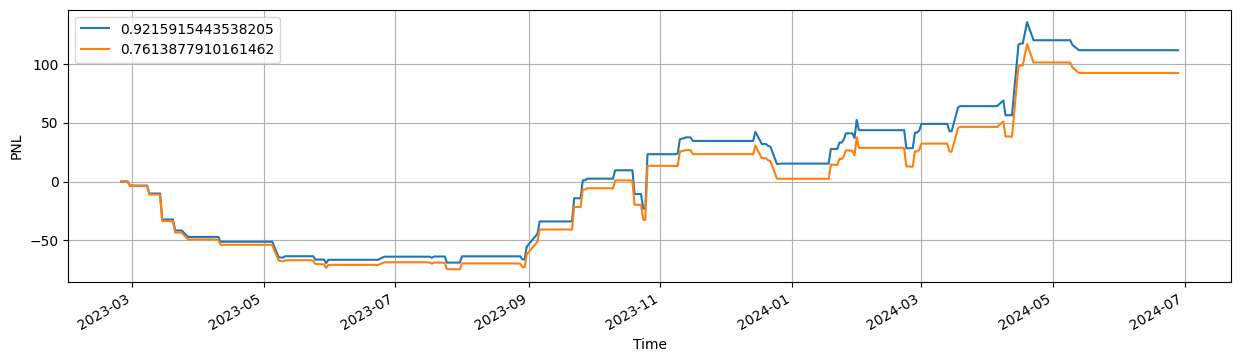

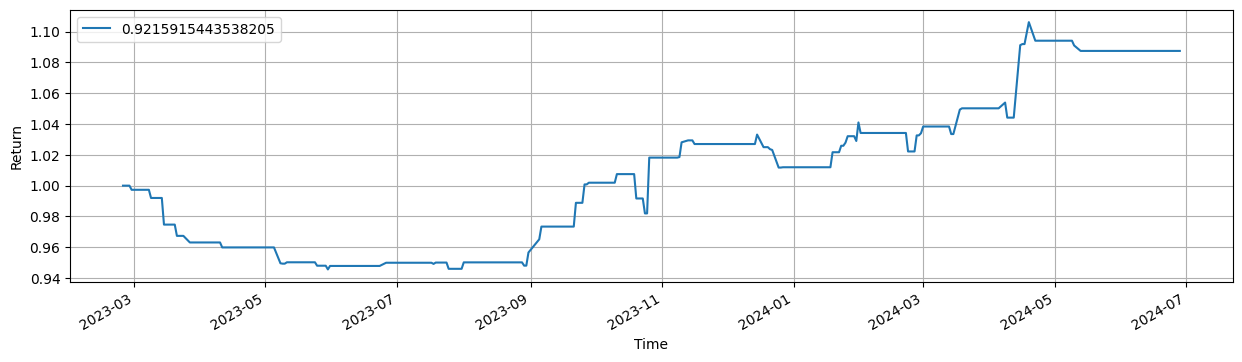

In [15]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [16]:
%%capture
data_VNI_position = test(data_VNI, 10)
data_VN30_position = test(data_VN30, 10)

Margin: -8.226041194836268
MDD: (178.29437500000088, 0.1387666848270233)

   Total trading quantity: 63
         Profit per trade: -1.9152380952381038
             Total Profit: -120.7
         Profit after fee: -148.5
 Trading quantity per day: 0.1875
 Profit per day after fee: -0.4419642857142857
                   Return: -0.0859182449519217
          Profit per year: -110.39205702647658
                  HitRate: 0.3968253968253968
          HitRate per day: 0.0955223880597015


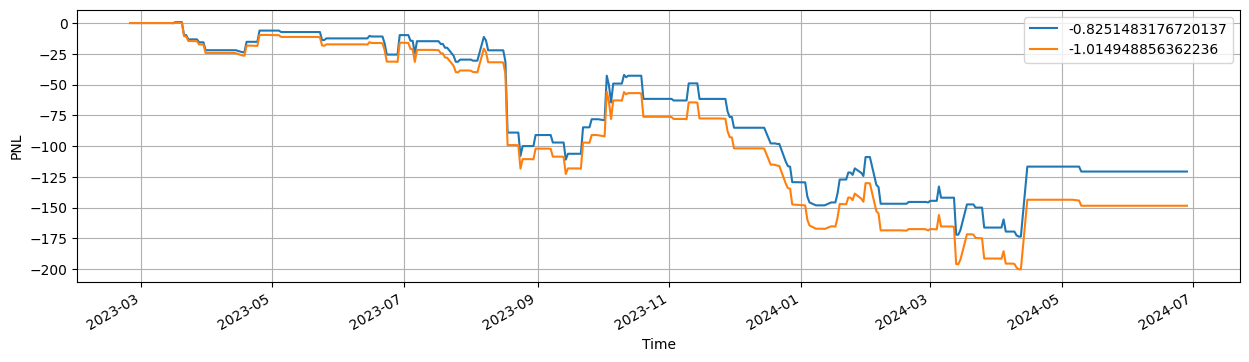

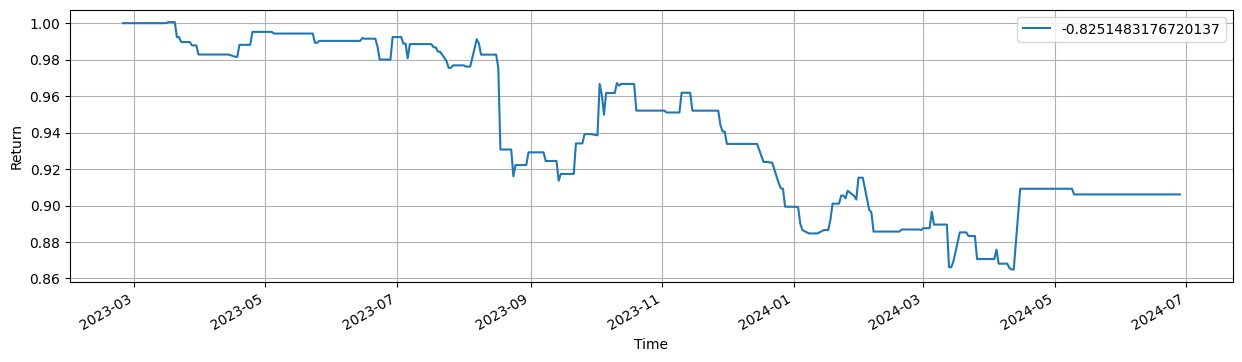

In [17]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 3.106890154542775
MDD: (63.50017857142906, 0.049741640742150296)

   Total trading quantity: 66
         Profit per trade: 0.7204545454545414
             Total Profit: 47.5
         Profit after fee: 18.3
 Trading quantity per day: 0.19642857142857142
 Profit per day after fee: 0.054464285714285715
                   Return: 0.010656329041021324
          Profit per year: 13.603869653767822
                  HitRate: 0.48484848484848486
          HitRate per day: 0.12835820895522387


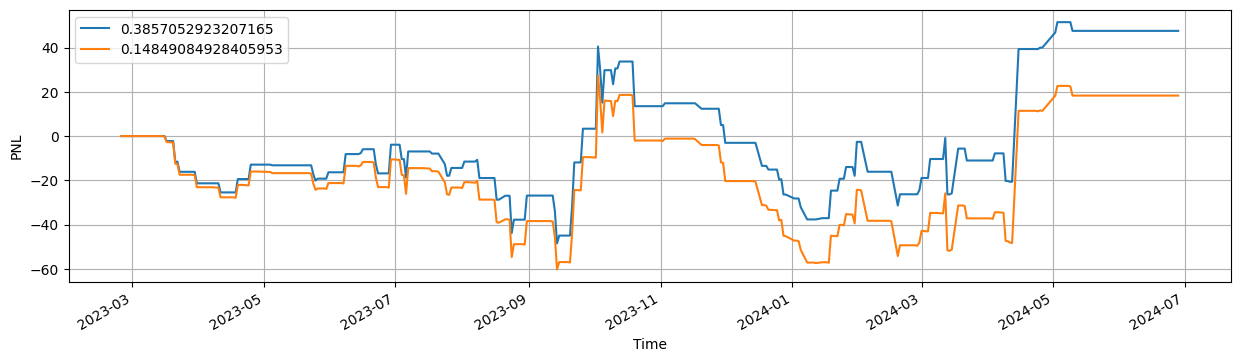

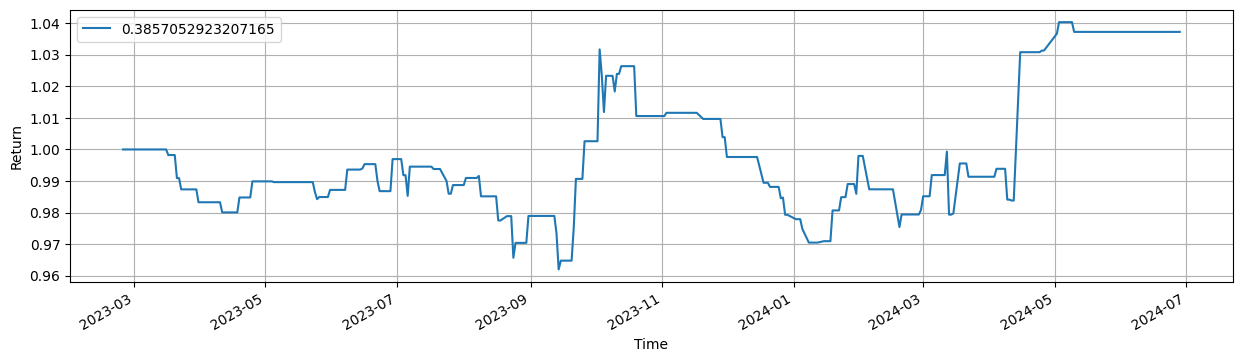

In [18]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [19]:
%%capture
data_VNI_position = test(data_VNI, 7)
data_VN30_position = test(data_VN30, 7)

Margin: 3.540937122959095
MDD: (77.64133928571457, 0.06007996539945413)

   Total trading quantity: 75
         Profit per trade: 0.8241333333333356
             Total Profit: 61.8
         Profit after fee: 28.1
 Trading quantity per day: 0.22321428571428573
 Profit per day after fee: 0.08363095238095239
                   Return: 0.01616420493434952
          Profit per year: 20.889002036659882
                  HitRate: 0.48
          HitRate per day: 0.12238805970149254


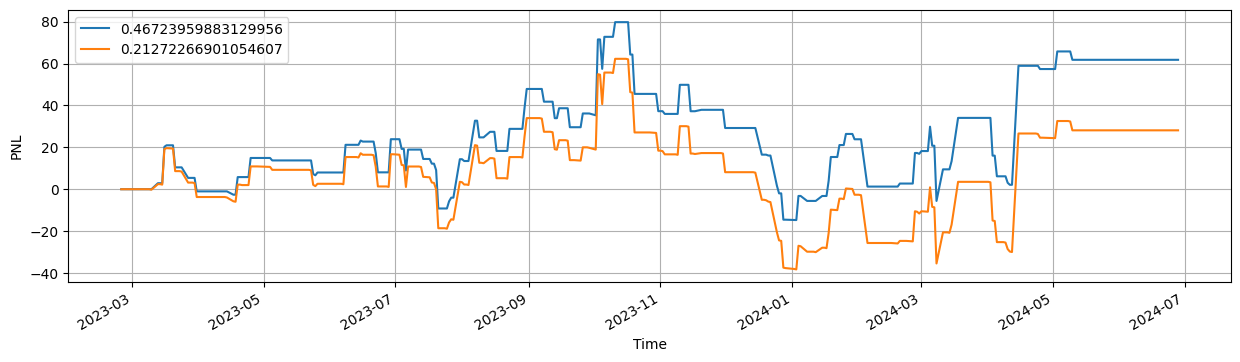

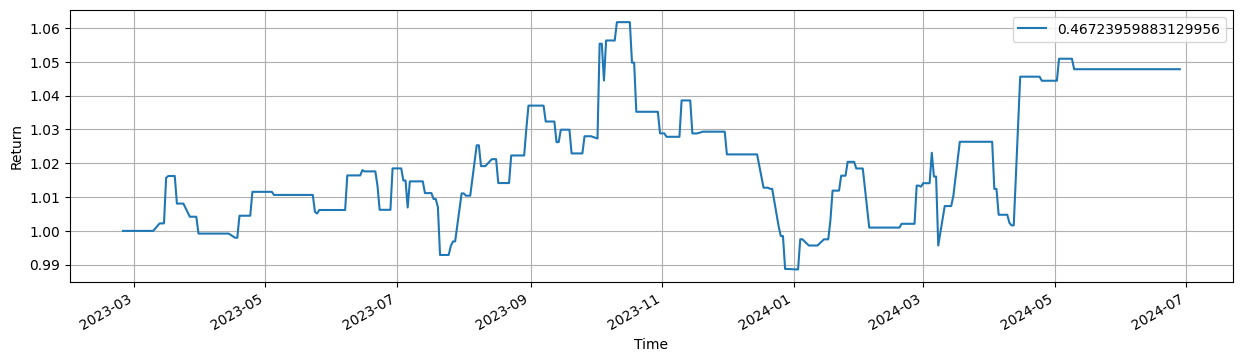

In [20]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 3.9765416118663683
MDD: (66.00517857142907, 0.05170388420133877)

   Total trading quantity: 71
         Profit per trade: 0.9254929577464666
             Total Profit: 65.7
         Profit after fee: 34.0
 Trading quantity per day: 0.2113095238095238
 Profit per day after fee: 0.10119047619047619
                   Return: 0.01979864411993033
          Profit per year: 25.274949083503056
                  HitRate: 0.49295774647887325
          HitRate per day: 0.1253731343283582


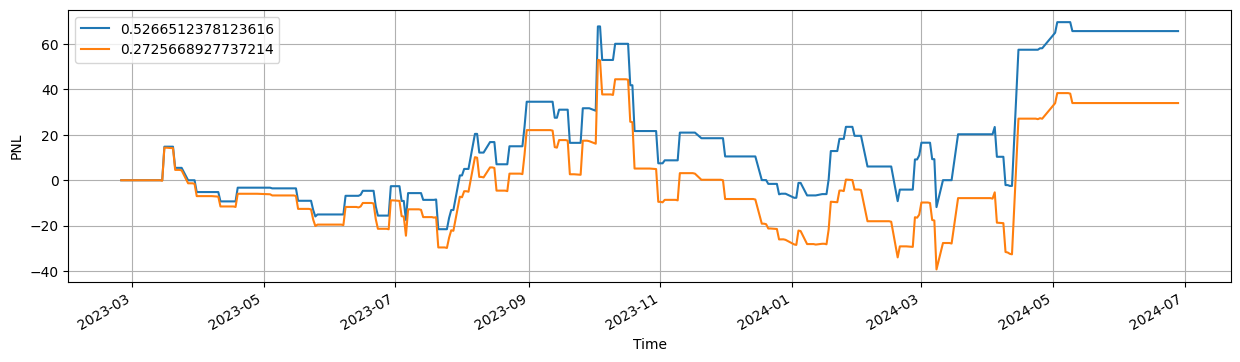

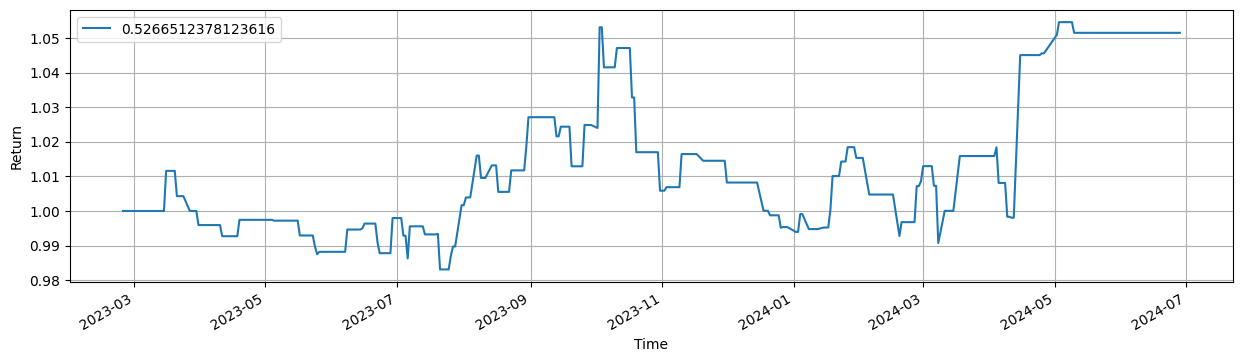

In [21]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()